In [1]:
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
from datasets import load_dataset

/home/saracandussio/.conda/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base = pd.read_csv('/home/saracandussio/tesi-risultati/results/baseline-phimini-hotpotqa.csv')
bart = pd.read_csv('/home/saracandussio/tesi-risultati/results/bart-phimini-hotpotqa.csv')
roberta = pd.read_csv('/home/saracandussio/tesi-risultati/results/roberta-phimini-hotpotqa.csv')
cot = pd.read_csv('/home/saracandussio/tesi-risultati/results/cot-phimini-hotpotqa.csv')
purecot = pd.read_csv('/home/saracandussio/tesi-risultati/results/pure-cot-phimini-hotpotqa.csv')
nocont = pd.read_csv('/home/saracandussio/tesi-risultati/results/nocontext-phimini-hotpotqa.csv')

In [4]:
def clean_text_final(text):
    text = re.sub(r'[^\w\s.,!?\'"\-:;()]+', '', text)  # Rimuove i caratteri speciali
    text = re.sub(r"['\"-]", '', text)  # Rimuove apostrofi, virgolette e trattini
    text = text.lower()  # Converte in minuscolo
    return text

In [5]:
base['correct'] = base['correct'].apply(clean_text_final)

base['thesis'] = base['thesis'].apply(clean_text_final)
base['synthesis'] = base['synthesis'].apply(clean_text_final)
base['goat'] = base['goat'].apply(clean_text_final)

bart['synthesis'] = bart['synthesis'].apply(clean_text_final)
roberta['synthesis'] = roberta['synthesis'].apply(clean_text_final)# 
cot['synthesis'] = cot['synthesis'].apply(clean_text_final)
purecot['answer'] = purecot['answer'].apply(clean_text_final)

nocont['thesis'] = nocont['thesis'].apply(clean_text_final)
nocont['synthesis'] = nocont['synthesis'].apply(clean_text_final)

# TL;DR

|which model|baseline - thesis|baseline - synthesis|bart - synthesis|roberta - synthesis| oracle - synthesis| nocontext - thesis | nocontext - synthesis | CoT as antithesis |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:| 
| phi-mini | 53.41% | 80.68% | 77.27% | 76.70% | 89.20% | 51.70% | 74.72% | 87.22% |

# Graphical comparison of success rates

In [6]:
def evaluation(correct_answer, candidate):
    matches = 0
    total = len(correct_answer)

    for i in range(total):
        
        if correct_answer[i] == candidate[i]:
            matches += 1

    return round(matches/total*100, 2)

In [7]:
print("Portion of correct thesis answers: {} %".format(evaluation(base['correct'], base['thesis'])))
print("Portion of correct baseline synthesis answers: {} %".format(evaluation(base['correct'], base['synthesis'])))
print("Portion of correct oracle synthesis answers: {} %".format(evaluation(base['correct'], base['goat'])))
print("Portion of correct BART synthesis answers: {} %".format(evaluation(bart['correct'], bart['synthesis'])))
print("Portion of correct RoBERTa synthesis answers: {} %".format(evaluation(roberta['correct'], roberta['synthesis'])))
print("Portion of correct CoT synthesis answers: {} %".format(evaluation(cot['correct'], cot['synthesis'])))
print("Portion of correct CoT answers: {} %".format(evaluation(base['correct'], purecot['answer'])))
print('##############################################################')
print("Portion of correct no context thesis answers: {} %".format(evaluation(nocont['correct'], nocont['thesis'])))
print("Portion of correct no context synthesis answers: {} %".format(evaluation(nocont['correct'], nocont['synthesis'])))

Portion of correct thesis answers: 53.41 %
Portion of correct baseline synthesis answers: 80.68 %
Portion of correct oracle synthesis answers: 89.2 %
Portion of correct BART synthesis answers: 77.27 %
Portion of correct RoBERTa synthesis answers: 76.7 %
Portion of correct CoT synthesis answers: 87.22 %
Portion of correct CoT answers: 88.92 %
##############################################################
Portion of correct no context thesis answers: 51.7 %
Portion of correct no context synthesis answers: 74.72 %


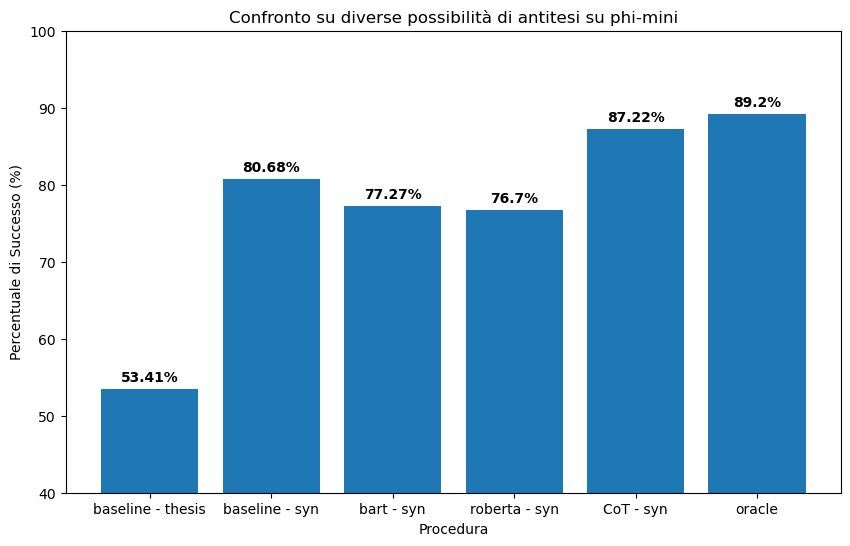

In [15]:
# Definire le procedure e le rispettive percentuali di successo
procedures = ['baseline - thesis', 'baseline - syn', 'bart - syn', 'roberta - syn', 'CoT - syn', 'oracle']
success_rates = [evaluation(base['correct'], base['thesis']), evaluation(base['correct'], base['synthesis']), 
                 evaluation(base['correct'], bart['synthesis']), evaluation(base['correct'], roberta['synthesis']),
                 evaluation(base['correct'], cot['synthesis']), evaluation(base['correct'], base['goat'])]

# Creare il barplot
plt.figure(figsize=(10, 6))
plt.bar(procedures, success_rates)

# Aggiungere etichette e titolo
plt.xlabel('Procedura')
plt.ylabel('Percentuale di Successo (%)')
plt.title('Confronto su diverse possibilità di antitesi su phi-mini')
plt.ylim(0, 100)  # Impostare il limite dell'asse y da 0 a 100

# Mostrare il valore di ciascun bar
for i, v in enumerate(success_rates):
    plt.text(i, v + 1, str(v) + '%', ha='center', fontweight='bold')

plt.ylim(40, )
# Mostrare il grafico
plt.show()

# Study on the correctness of NLI verifiers statements

i.e. BART and RoBERTa performs worst than a "normal" LLM critique, but why? Are they wrong? Or maybe the "standard" antithesis is more verbose (and thus more decisive)?

In [8]:
mean_tokens_baseline = base['antithesis'].apply(len).mean()
mean_tokens_bart = bart['antithesis'].apply(len).mean()
mean_tokens_roberta = roberta['antithesis'].apply(len).mean()

In [9]:
print(mean_tokens_baseline) # more verbose!
print(mean_tokens_bart)
print(mean_tokens_roberta)

244.27272727272728
59.76420454545455
59.63636363636363


Check of the correctness of both BART and ROBERTA answers: the NLi statement is chosen by looking at the probabilities of entailment of both the NLI statements & by choosing the most probable one. Thus we can directly test the correctness of the suggestion, not only the final echo of the suggestion (i.e. passed through the pipeline). 

In [16]:
import datasets
from datasets import load_dataset

dataset = load_dataset('saracandu/hotpotQA_nli', split="train")

correct_answers = dataset['answer']
possibilities = dataset['options']

bart1 = dataset['BART1']
bart2 = dataset['BART2']

rob1 = dataset['ROBERTA1']
rob2 = dataset['ROBERTA2']

In [17]:
candidates_bart = []
candidates_roberta = []

for i in range(len(dataset)):

    possibilities[i] = ast.literal_eval(possibilities[i]) # questo basta farlo una volta

    if bart1[i] > bart2[i]:
        candidates_bart.append(possibilities[i][0])
    else:
        candidates_bart.append(possibilities[i][1])

    if rob1[i] > rob2[i]:
        candidates_roberta.append(possibilities[i][0])
    else:
        candidates_roberta.append(possibilities[i][1])

In [12]:
print("Portion of correct BART suggestions: {} %".format(evaluation(correct_answers, candidates_bart)))
print("Portion of correct ROBERTA suggestions: {} %".format(evaluation(correct_answers, candidates_roberta)))

Portion of correct BART suggestions: 55.97 %
Portion of correct ROBERTA suggestions: 52.84 %


Thus the suggestions given by the NLI verifier are not so far from choosing randomly one options between the two! This means that, even if the suggestion is wrong, the pipeline is robust and reaches good accuracies for both BART and RoBERTa (`77.27 %` and `76.7 %` respectively).

But maybe these good performances are due to a good "intuitive" guess proposed by the thesis? No! The thesis only guesses correctly `53.41 %` of the overall answers and is paired with an antithesis (BART & RoBERTa) almost equal in terms of performances. 

This means that is the process of putting together different suggestions (thesis and antithesis, no matter if they are right or wrong) and re-thinking of the answer given the context that causes big improvements in the prediction accuracies. 

Now we have to consider the percentage of correct thesis answers compared to the correctness of the BART and RoBERTa suggestions:

In [18]:
def study_overlap(correct, thesis, candidate):

    match_solo_tesi = 0
    match_solo_antitesi = 0
    match_entrambi = 0
    total = len(correct)

    for i in range(total):
        
        if correct[i] == thesis[i] and correct[i] == candidate[i]:
            match_entrambi += 1
        elif correct[i] == thesis[i]:
            match_solo_tesi += 1
        elif correct[i] == candidate[i]:
            match_solo_antitesi += 1

    return round(match_entrambi/total*100, 2), round(match_solo_tesi/total*100, 2), round(match_solo_antitesi/total*100, 2)

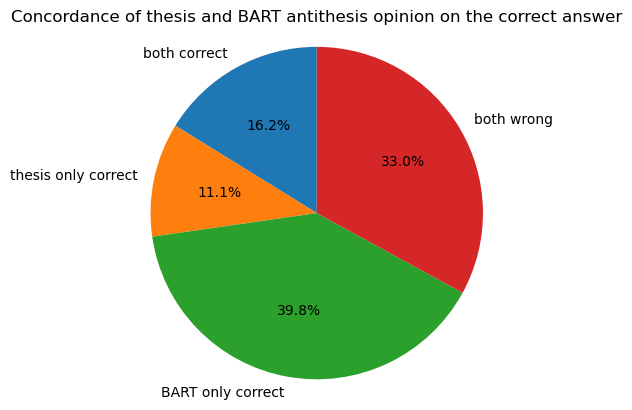

In [14]:
both, thesis_only, antithesis_only = study_overlap(correct_answers, base['thesis'], candidates_bart)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'both correct', 'thesis only correct', 'BART only correct', 'both wrong'
sizes = [both, thesis_only, antithesis_only, 100-(both+thesis_only+antithesis_only)]

fig1, ax1 = plt.subplots()
ax1.set_title("Concordance of thesis and BART antithesis opinion on the correct answer")
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  

plt.show()

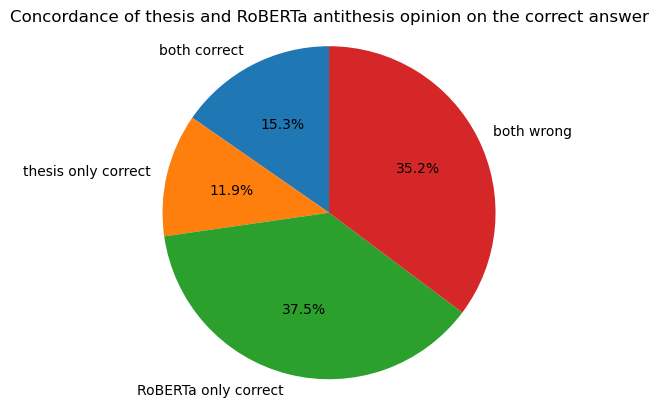

In [15]:
both, thesis_only, antithesis_only = study_overlap(correct_answers, base['thesis'], candidates_roberta)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'both correct', 'thesis only correct', 'RoBERTa only correct', 'both wrong'
sizes = [both, thesis_only, antithesis_only, 100-(both+thesis_only+antithesis_only)]

fig1, ax1 = plt.subplots()
ax1.set_title("Concordance of thesis and RoBERTa antithesis opinion on the correct answer")
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  

plt.show()

In [19]:
def subset_tesi(correct, thesis, other, obj):

    thesis_correct_matches = 0
    thesis_incorrect_matches = 0

    num_thesis_matches = 0
    total = len(correct)

    for i in range(total):

        if correct[i] == thesis[i]:
            num_thesis_matches += 1
            if correct[i] == other[i]:
                thesis_correct_matches += 1

        else: 
            if correct[i] == other[i]:
                thesis_incorrect_matches += 1
   
    print("correct {} and correct synthesis: {} %".format(obj, round(thesis_correct_matches/num_thesis_matches*100, 2)))
    print("correct {} but incorrect synthesis: {} %".format(obj, round((num_thesis_matches - thesis_correct_matches)/num_thesis_matches*100, 2)))
    # if thesis != correct:
    print("incorrect {} but coROBERTArrect synthesis {} %".format(obj, round(thesis_incorrect_matches/(total-num_thesis_matches)*100, 2)))
    print("incorrect {} and incorrect synthesis: {} %".format(obj, round((total - num_thesis_matches - thesis_incorrect_matches)/(total-num_thesis_matches)*100, 2)))

def subset_tesi_abs(correct, thesis, other, obj1, obj2):

    thesis_correct_matches = 0
    thesis_incorrect_matches = 0

    num_thesis_matches = 0
    total = len(correct)

    for i in range(total):

        if correct[i] == thesis[i]:
            num_thesis_matches += 1
            if correct[i] == other[i]:
                thesis_correct_matches += 1

        else: 
            if correct[i] == other[i]:
                thesis_incorrect_matches += 1
   
    print("correct {} and correct {}: {}".format(obj1, obj2, thesis_correct_matches))
    print("correct {} but incorrect {}: {}".format(obj1, obj2, (num_thesis_matches - thesis_correct_matches)))
    # if thesis != correct:
    print("incorrect {} but correct {}; {}".format(obj1, obj2, thesis_incorrect_matches))
    print("incorrect {} and incorrect {}: {}".format(obj1, obj2, (total - num_thesis_matches - thesis_incorrect_matches)))

In [20]:
print("extremely verbose confusion matrices incoming...") 
print('***************')

print("BASELINE:")
subset_tesi(correct_answers, base['thesis'], base['synthesis'], 'thesis')
print('-------------')
print("BART:")
subset_tesi(correct_answers, bart['thesis'], bart['synthesis'], 'thesis')
print('-------------')
print("ROBERTA:")
subset_tesi(correct_answers, roberta['thesis'], roberta['synthesis'], 'thesis')
print('-------------')
print("CoT as antithesis:")
subset_tesi(correct_answers, base['thesis'], cot['synthesis'], 'thesis')
print('-------------')
print("ORACLE:")
subset_tesi(correct_answers, base['thesis'], correct_answers, 'thesis')

extremely verbose confusion matrices incoming...
***************
BASELINE:
correct thesis and correct synthesis: 78.12 %
correct thesis but incorrect synthesis: 21.88 %
incorrect thesis but coROBERTArrect synthesis 24.22 %
incorrect thesis and incorrect synthesis: 75.78 %
-------------
BART:
correct thesis and correct synthesis: 93.75 %
correct thesis but incorrect synthesis: 6.25 %
incorrect thesis but coROBERTArrect synthesis 16.8 %
incorrect thesis and incorrect synthesis: 83.2 %
-------------
ROBERTA:
correct thesis and correct synthesis: 93.75 %
correct thesis but incorrect synthesis: 6.25 %
incorrect thesis but coROBERTArrect synthesis 16.41 %
incorrect thesis and incorrect synthesis: 83.59 %
-------------
CoT as antithesis:
correct thesis and correct synthesis: 87.5 %
correct thesis but incorrect synthesis: 12.5 %
incorrect thesis but coROBERTArrect synthesis 24.22 %
incorrect thesis and incorrect synthesis: 75.78 %
-------------
ORACLE:
correct thesis and correct synthesis: 100

In [21]:
print("BASELINE:")
print("baseline antithesis needs to be extracted - work in progress")
print('-------------')
print("CoT as antithesis:")
print("CoT antithesis needs to be extracted - work in progress")
print('-------------')
print("BART:")
subset_tesi(correct_answers, candidates_bart, bart['synthesis'], 'antithesis')
print('-------------')
print("ROBERTA:")
subset_tesi(correct_answers, candidates_roberta, roberta['synthesis'], 'antithesis')
print('-------------')
print("ORACLE:")
subset_tesi(correct_answers, correct_answers, base['goat'], 'antithesis')

BASELINE:
baseline antithesis needs to be extracted - work in progress
-------------
CoT as antithesis:
CoT antithesis needs to be extracted - work in progress
-------------
BART:
correct antithesis and correct synthesis: 33.5 %
correct antithesis but incorrect synthesis: 66.5 %
incorrect antithesis but coROBERTArrect synthesis 43.23 %
incorrect antithesis and incorrect synthesis: 56.77 %
-------------
ROBERTA:
correct antithesis and correct synthesis: 32.8 %
correct antithesis but incorrect synthesis: 67.2 %
incorrect antithesis but coROBERTArrect synthesis 42.77 %
incorrect antithesis and incorrect synthesis: 57.23 %
-------------
ORACLE:
correct antithesis and correct synthesis: 45.17 %
correct antithesis but incorrect synthesis: 54.83 %


ZeroDivisionError: division by zero

# Impact of the best suggestion

But what about passing to the pipeline the correct answer as antithesis and trying to see the absorbing abilities of the pipeline? Which is the improvement? 
This is done in the column `goat` of the `base` file.

*(This is an important test since the previous result could suggest that the method could be indifferent to the suggestion, and this is not the case)*

In [22]:
print("Portion of correct GOAT suggestions: {} %".format(evaluation(base['correct'], base['goat'])))

Portion of correct GOAT suggestions: 89.2 %


Thus the correct suggestion has a positive on the prediction abilites of the model, even if it is NOT verbose: 

In [23]:
mean_tokens_goat = base['goat_antithesis'].apply(len).mean()
print(mean_tokens_goat) # the more succinct overall!

31.085227272727273


Of course, the portion of correct suggestions given by the antithesis in this scenario is 100%, thus it is clear that this pipeline does not faithfully blindly follows the suggestions. 
On the other hand, this intrinsic skepticism helps to check on the context and elaborate a new, synthetic answer. This means that in scenario in which the context is deceiving (or contains numbers/dates/difficult logical links to perform) even the perfect suggestion fails to convince the LLM on which is the correct option. 

It has not been performed an ablation study on the impacts of different "perfect suggestions" beyond the standard (i.e. `"the correct option is " + correct_answer + " since the other options are not mentioned in the context"`), since a concrete reference on the source documents would imply hand-crafted suggestions. 

# Sankey Diagrams for the "change of opinion" during the pipeline

In [22]:
print("extremely verbose confusion matrices incoming...") 
print('***************')

print("BASELINE:")
print("baseline antithesis needs to be extracted - work in progress")
print('-------------')
print("BASELINE:")
print("CoT antithesis needs to be extracted - work in progress")
print('-------------')
print("BART:")
subset_tesi_abs(correct_answers, bart['thesis'], candidates_bart, 'thesis', 'antithesis')
print('-------------')
print("ROBERTA:")
subset_tesi_abs(correct_answers, roberta['thesis'], candidates_roberta, 'thesis', 'antithesis')
print('-------------')
print("ORACLE:")
subset_tesi_abs(correct_answers, base['thesis'], base['goat'], 'thesis', 'antithesis')

extremely verbose confusion matrices incoming...
***************
BASELINE:
baseline antithesis needs to be extracted - work in progress
-------------
BASELINE:
CoT antithesis needs to be extracted - work in progress
-------------
BART:
correct thesis and correct antithesis: 57
correct thesis but incorrect antithesis: 39
incorrect thesis but correct antithesis; 140
incorrect thesis and incorrect antithesis: 116
-------------
ROBERTA:
correct thesis and correct antithesis: 54
correct thesis but incorrect antithesis: 42
incorrect thesis but correct antithesis; 132
incorrect thesis and incorrect antithesis: 124
-------------
ORACLE:
correct thesis and correct antithesis: 91
correct thesis but incorrect antithesis: 5
incorrect thesis but correct antithesis; 68
incorrect thesis and incorrect antithesis: 188


In [25]:
print("BASELINE:")
print("baseline antithesis needs to be extracted - work in progress")
print('-------------')
print("BART:")
subset_tesi_abs(correct_answers, candidates_bart, bart['synthesis'], 'antithesis', 'synthesis')
print('-------------')
print("ROBERTA:")
subset_tesi_abs(correct_answers, candidates_roberta, roberta['synthesis'], 'antithesis', 'synthesis')
print('-------------')
print("ORACLE:")
subset_tesi_abs(correct_answers, correct_answers, base['goat'], 'antithesis', 'synthesis')

BASELINE:
baseline antithesis needs to be extracted - work in progress
-------------
BART:
correct antithesis and correct synthesis: 66
correct antithesis but incorrect synthesis: 131
incorrect antithesis but correct synthesis; 67
incorrect antithesis and incorrect synthesis: 88
-------------
ROBERTA:
correct antithesis and correct synthesis: 61
correct antithesis but incorrect synthesis: 125
incorrect antithesis but correct synthesis; 71
incorrect antithesis and incorrect synthesis: 95
-------------
ORACLE:
correct antithesis and correct synthesis: 159
correct antithesis but incorrect synthesis: 193
incorrect antithesis but correct synthesis; 0
incorrect antithesis and incorrect synthesis: 0


In [26]:
import plotly.graph_objects as go

label_list = ['correct thesis', 'incorrect thesis', 'correct antithesis', 'incorrect antithesis', 'correct synthesis', 'incorrect synthesis']
# correct thesis: 0, incorrect thesis: 1, correct antithesis: 2, incorrect antithesis: 3, correct synthesis: 4, incorrect synthesis: 5
source = [0, 0, 1, 1, 2, 2, 3, 3]
target = [2, 3, 2, 3, 4, 5, 4, 5]
count = [57, 39, 140, 116, 66, 131, 67, 88]


fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])

fig.update_layout(title_text="BART", font_size=10, width=600, height=400)

fig.show()

In [27]:
label_list = ['correct thesis', 'incorrect thesis', 'correct antithesis', 'incorrect antithesis', 'correct synthesis', 'incorrect synthesis']
# correct thesis: 0, incorrect thesis: 1, correct antithesis: 2, incorrect antithesis: 3, correct synthesis: 4, incorrect synthesis: 5
source = [0, 0, 1, 1, 2, 2, 3, 3]
target = [2, 3, 2, 3, 4, 5, 4, 5]
count = [54, 42, 132, 124, 61, 125, 71, 95]


fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])

fig.update_layout(title_text="RoBERTa", font_size=10, width=600, height=400)

fig.show()